In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
# MNIST 데이터 로드 및 전처리
transform = transforms.Compose([
transforms.ToTensor()
])
train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = MNIST(root='./data', train=False, transform=transform, download=True)
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# 하이퍼파라미터 설정
latent_dim = 100
hidden_dim = 256
image_dim = 28*28

In [2]:
# Discriminator 모델 정의
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
        nn.Linear(image_dim, hidden_dim),
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_dim, hidden_dim),
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_dim, 1),
        nn.Sigmoid()
        )
    def forward(self, x):
        x = x.view(-1, image_dim)
        return self.model(x)
# Generator 모델 정의
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
        nn.Linear(latent_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, image_dim),
        nn.Tanh()
        )
    def forward(self, z):
        img = self.model(z)
        return img.view(-1, 1, 28, 28)

In [13]:
# 모델 초기화
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
discriminator = Discriminator().to(device)
generator = Generator().to(device)
# 손실 함수와 옵티마이저 정의
criterion = nn.BCELoss()
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
# 학습
num_epochs = 200
d_steps = 1 # discriminator 학습 스텝 수
g_steps = 1 # generator 학습 스텝 수
print("Starting Training...")
for epoch in range(num_epochs):
    d_losses = []
    g_losses = []
    for i, (real_images, _) in enumerate(train_loader):
        batch_size = real_images.size(0)
        real_images = real_images.to(device)
        for _ in range(d_steps):
            d_optimizer.zero_grad()
            label_real = torch.ones(batch_size, 1).to(device)
            label_fake = torch.zeros(batch_size, 1).to(device)
            # Real images
            output_real = discriminator(real_images)
            d_loss_real = criterion(output_real, label_real)
            # Fake images
            z = torch.randn(batch_size, latent_dim).to(device)
            fake_images = generator(z)
            output_fake = discriminator(fake_images.detach())
            d_loss_fake = criterion(output_fake, label_fake)
            # Total discriminator loss
            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            d_optimizer.step()
        d_losses.append(d_loss.item())
        # Train Generator
        for _ in range(g_steps):
            g_optimizer.zero_grad()
            z = torch.randn(batch_size, latent_dim).to(device)
            fake_images = generator(z)
            output = discriminator(fake_images)
            g_loss = criterion(output, label_real)
            g_loss.backward()
            g_optimizer.step()
        g_losses.append(g_loss.item())
        # 에폭마다 결과 출력
    if epoch % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], d_loss: {np.mean(d_losses):.4f}, g_loss: {np.mean(g_losses):.4f}')
        # 샘플 이미지 생성
        with torch.no_grad():
            test_z = torch.randn(25, latent_dim).to(device)
            generated = generator(test_z)
            plt.figure(figsize=(10, 10))
            for i in range(25):
                plt.subplot(5, 5, i+1)
                plt.imshow(generated[i].cpu().squeeze(), cmap='gray')
                plt.axis('off')
            plt.suptitle(f'Epoch {epoch+1}')
            plt.show()
print("Training finished!")

Starting Training...



KeyboardInterrupt



Starting Training...


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:13<00:00, 34.25it/s]


Epoch [10/200], d_loss: 0.4223, g_loss: 4.2615


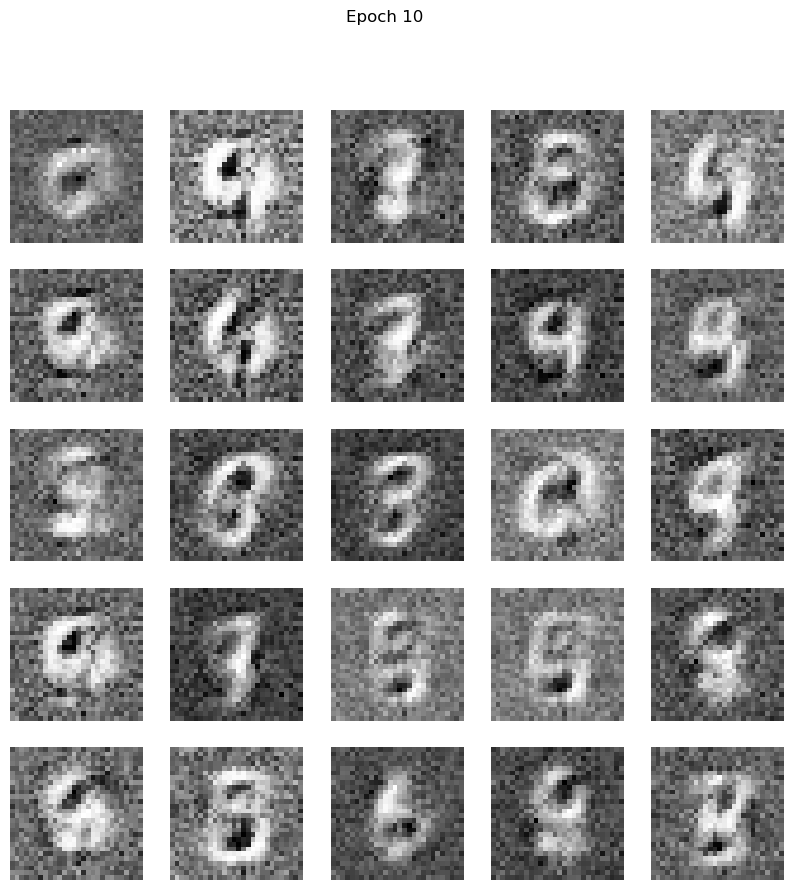

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:14<00:00, 33.13it/s]


Epoch [20/200], d_loss: 0.4530, g_loss: 4.1242


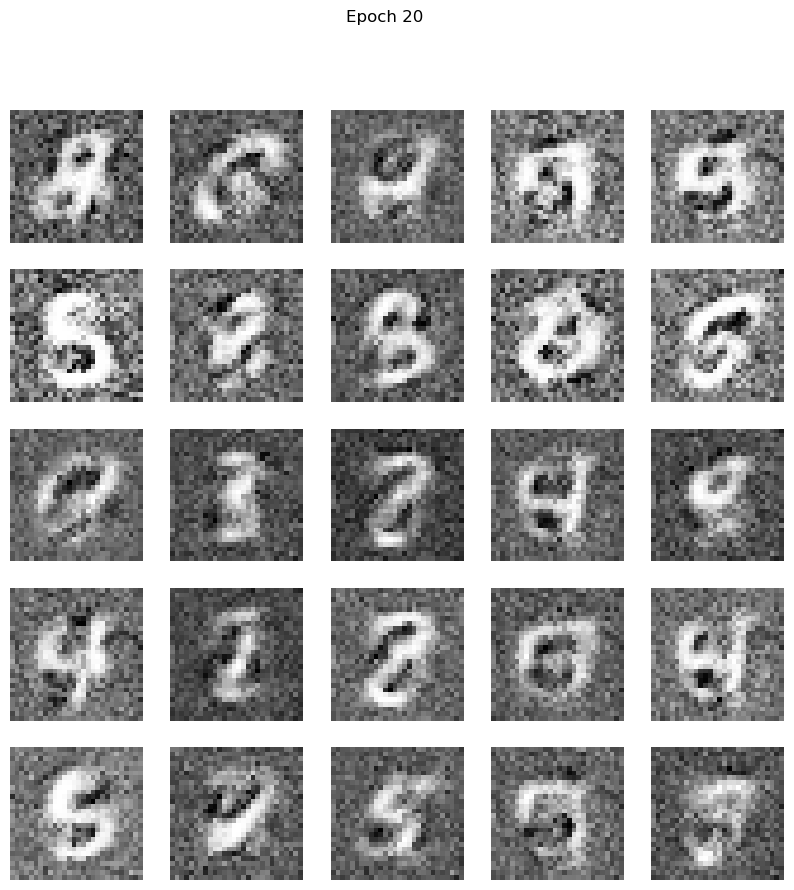

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:12<00:00, 38.84it/s]


Epoch [30/200], d_loss: 0.5408, g_loss: 3.4103


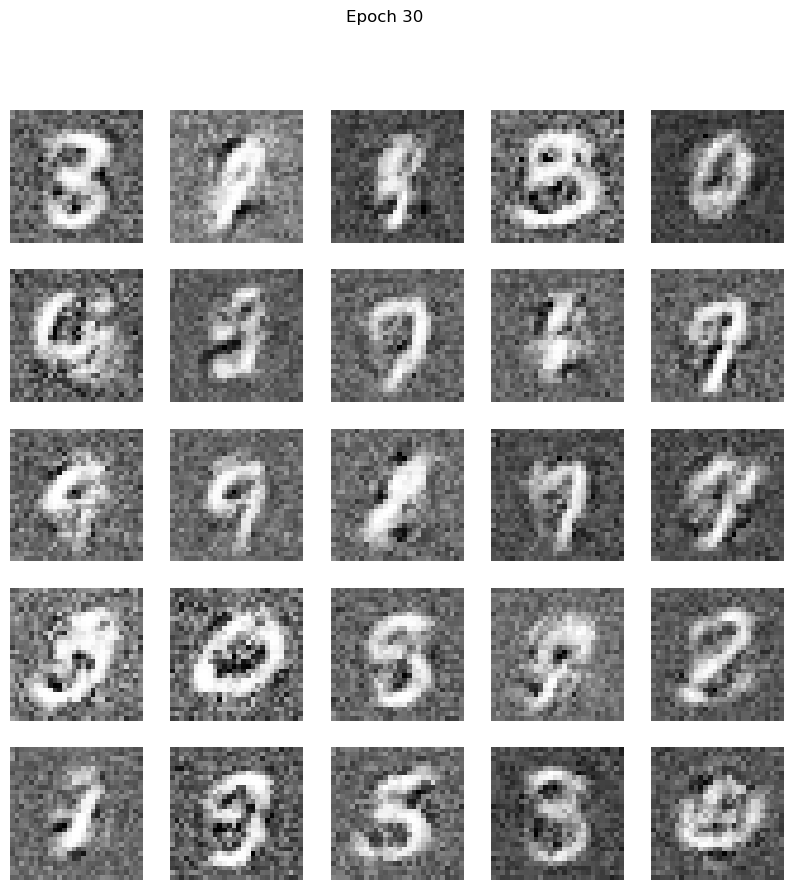

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:12<00:00, 38.98it/s]


Epoch [40/200], d_loss: 0.6041, g_loss: 3.0213


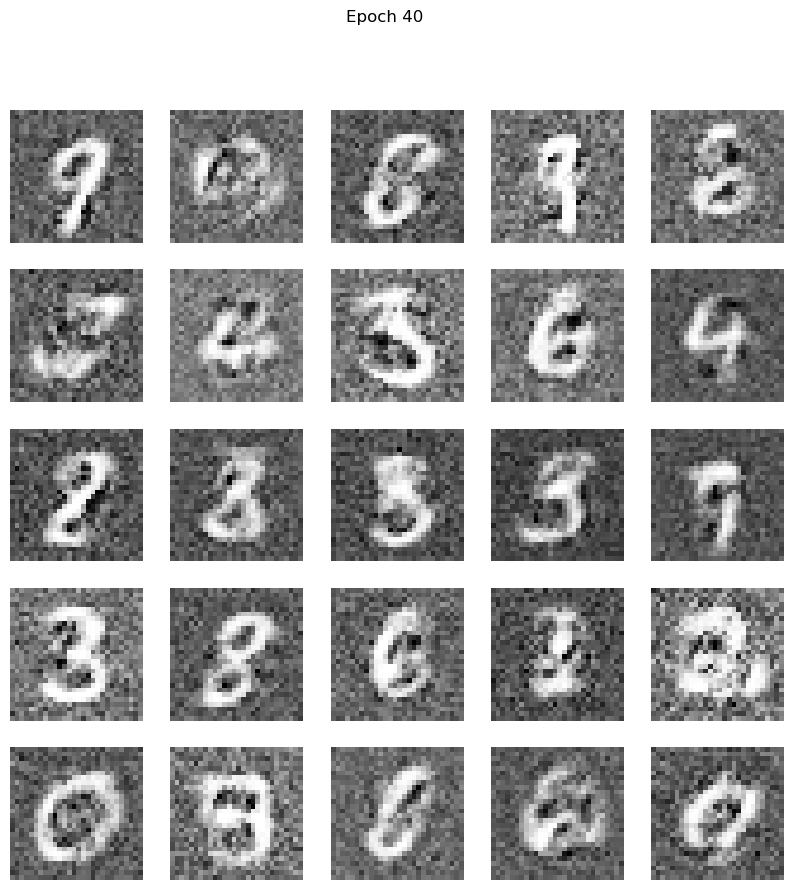

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:12<00:00, 38.54it/s]


Epoch [50/200], d_loss: 0.6858, g_loss: 2.5379


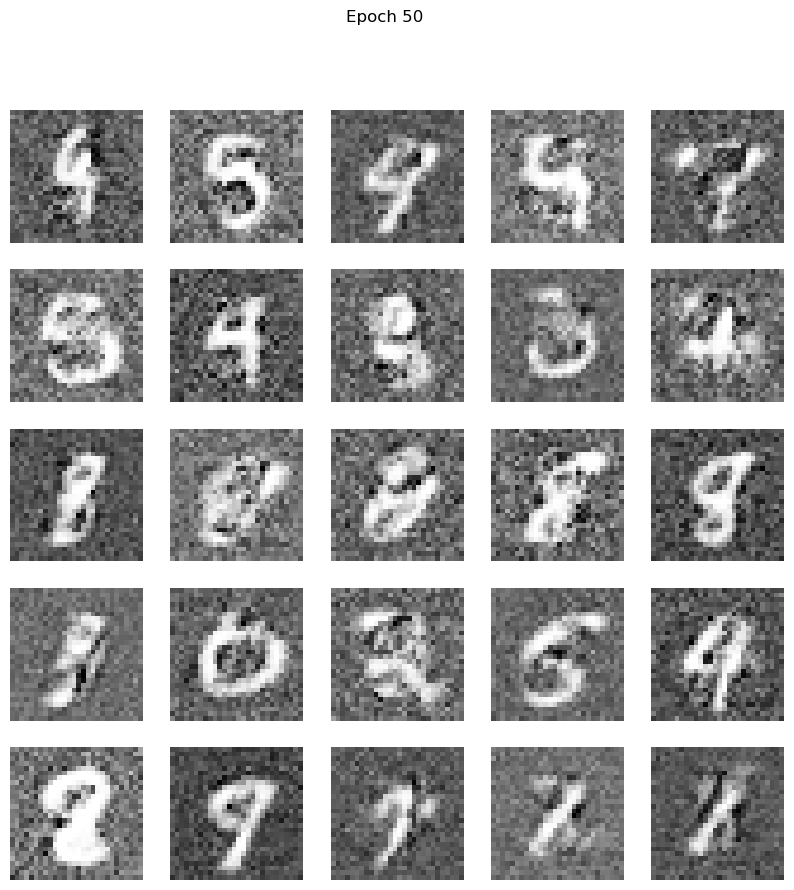

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:14<00:00, 33.24it/s]


Epoch [60/200], d_loss: 0.7140, g_loss: 2.2625


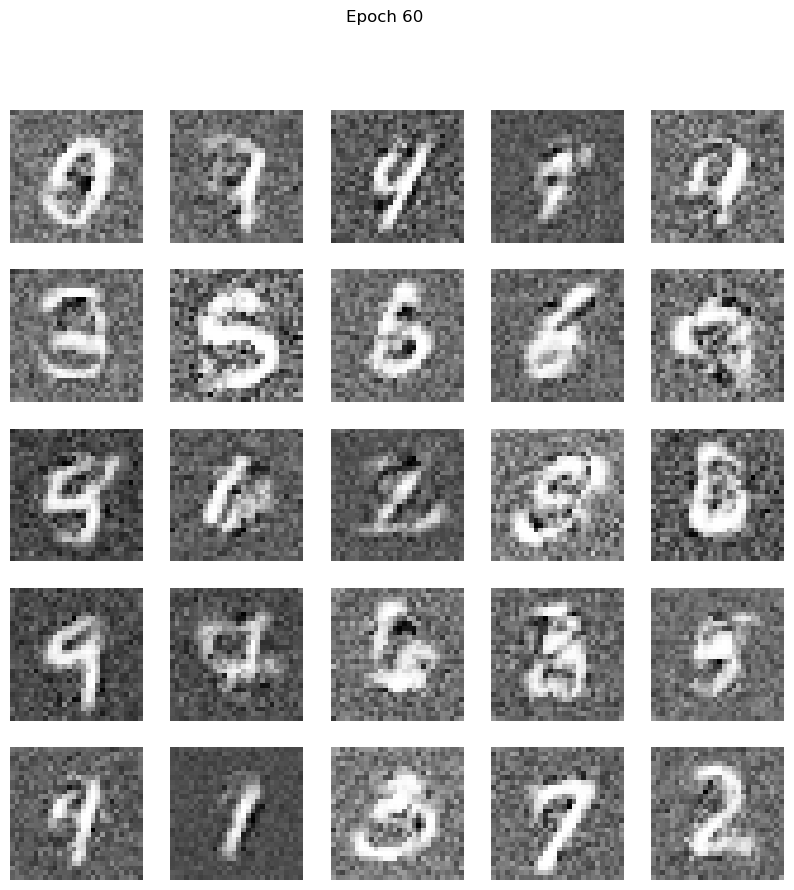

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:12<00:00, 37.66it/s]


Epoch [70/200], d_loss: 0.7512, g_loss: 2.0937


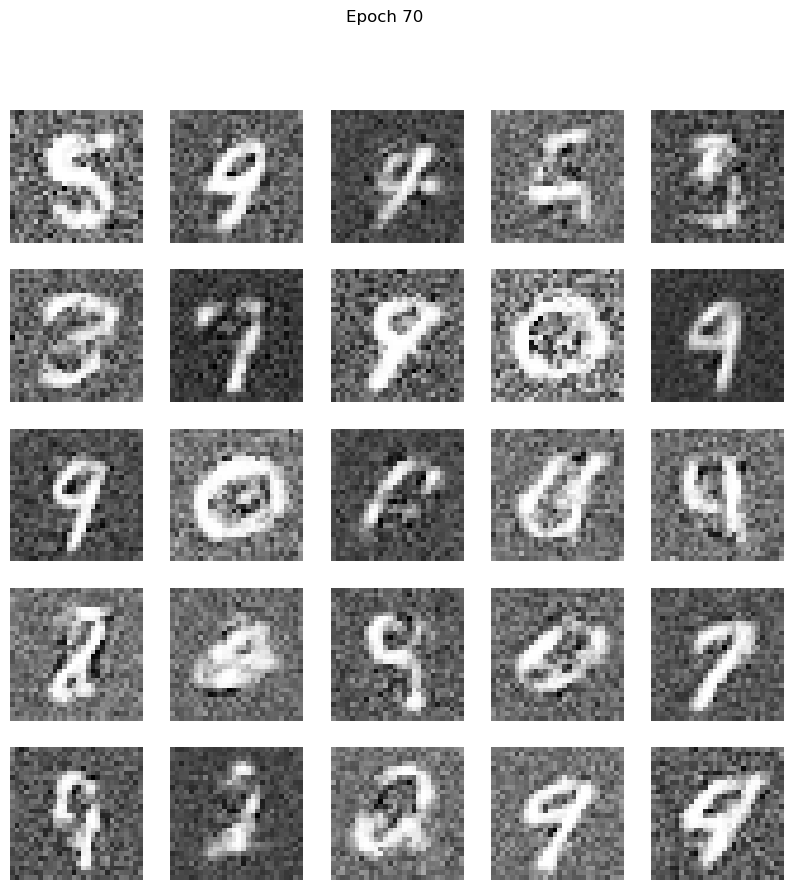

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:12<00:00, 37.03it/s]


Epoch [80/200], d_loss: 0.7469, g_loss: 2.0414


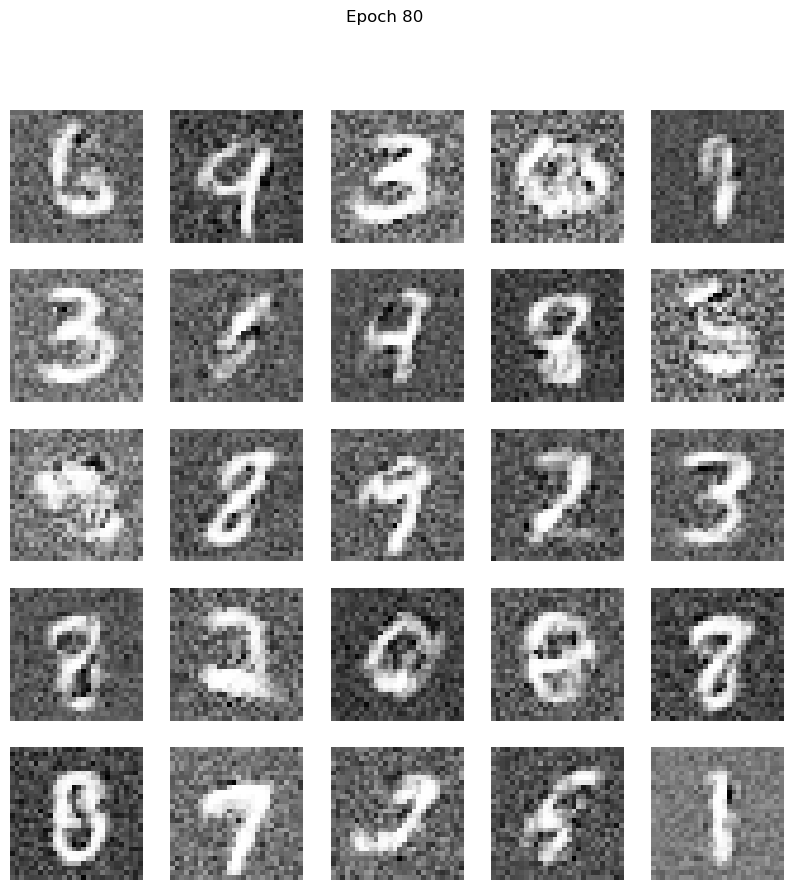

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:13<00:00, 33.52it/s]


Epoch [90/200], d_loss: 0.7431, g_loss: 1.9956


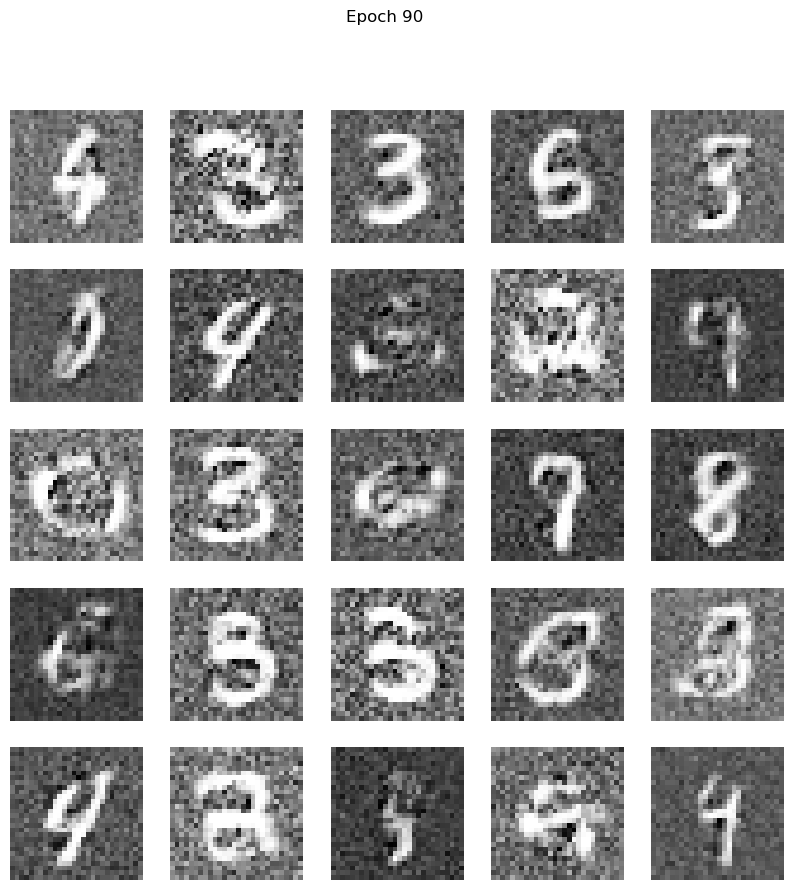

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:12<00:00, 38.16it/s]


Epoch [100/200], d_loss: 0.7232, g_loss: 2.0196


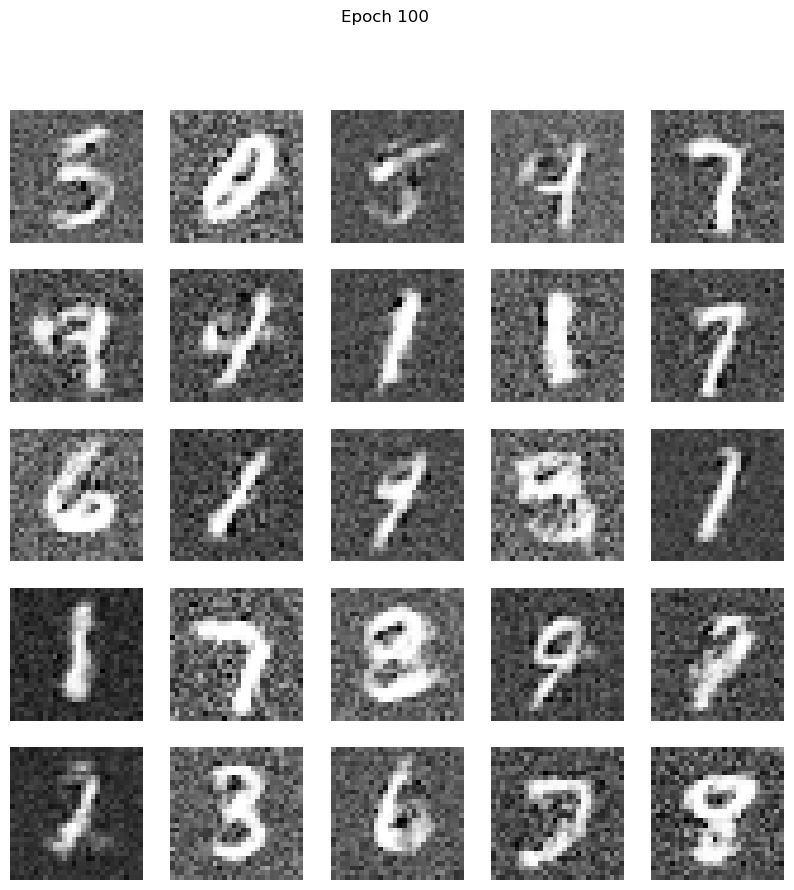

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:14<00:00, 33.41it/s]


Epoch [110/200], d_loss: 0.6962, g_loss: 2.0832


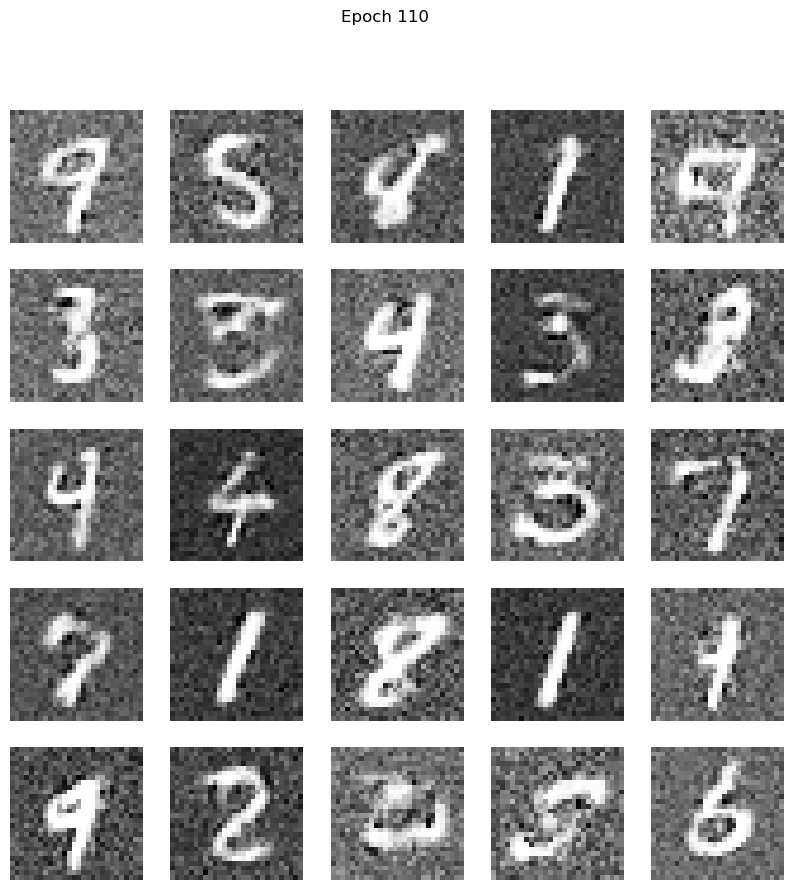

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:13<00:00, 35.76it/s]


Epoch [120/200], d_loss: 0.6950, g_loss: 2.0970


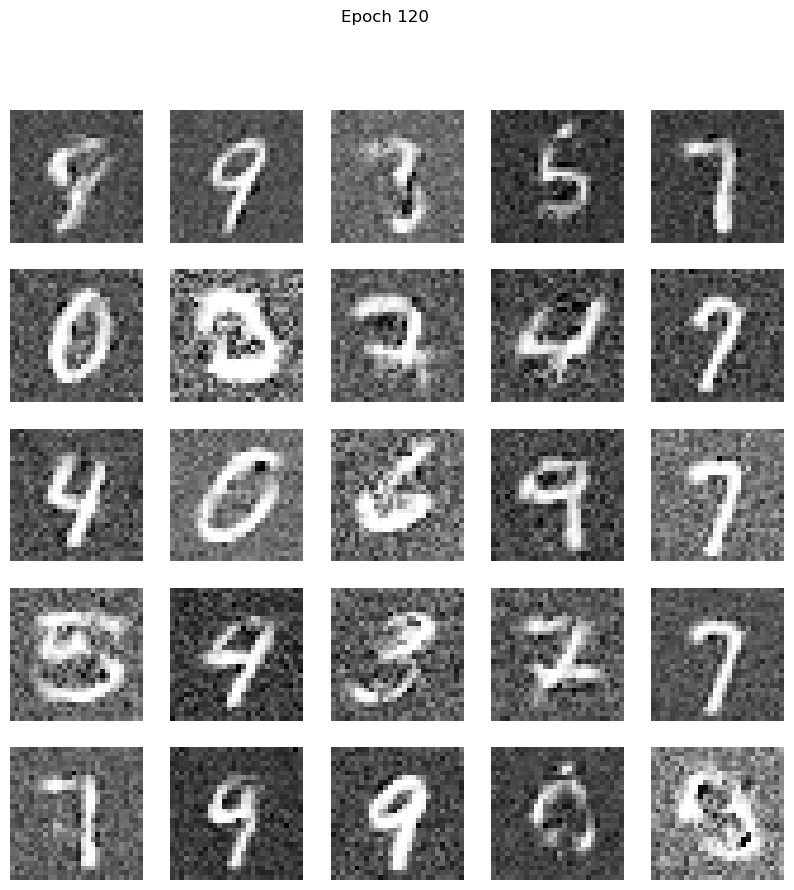

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:12<00:00, 36.49it/s]


Epoch [130/200], d_loss: 0.6811, g_loss: 2.1417


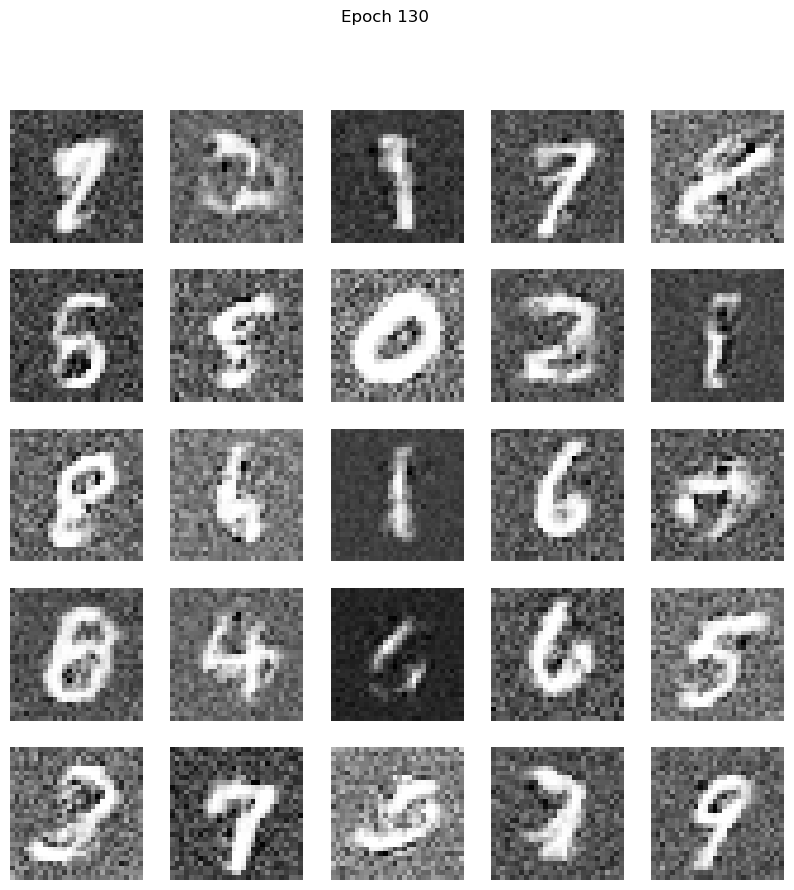

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:12<00:00, 36.82it/s]


Epoch [140/200], d_loss: 0.6747, g_loss: 2.1690


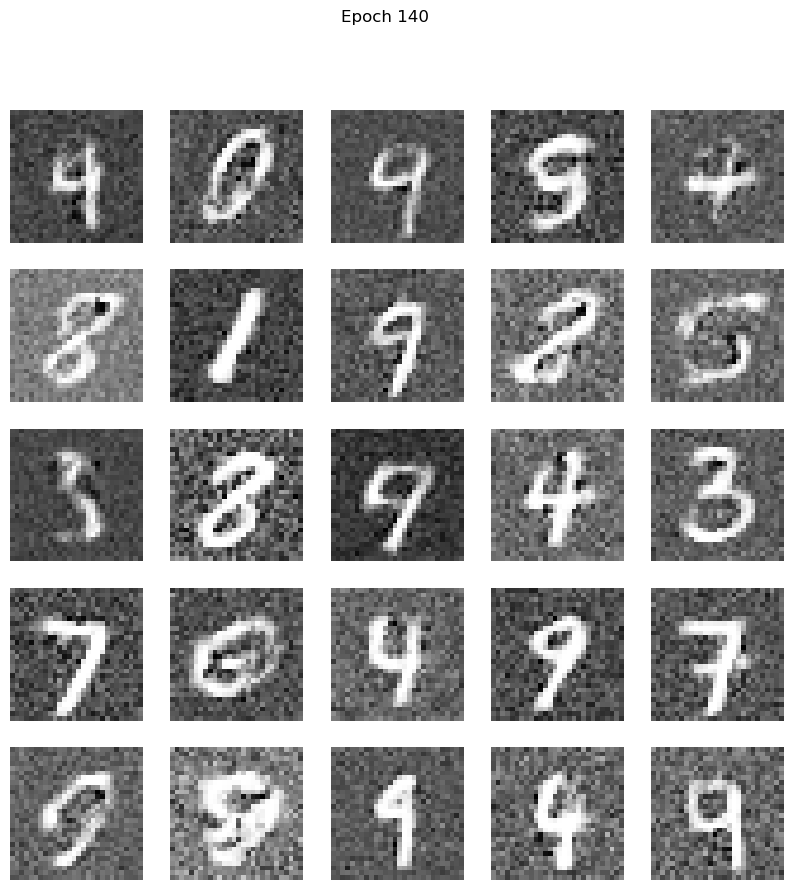

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:13<00:00, 35.07it/s]


Epoch [150/200], d_loss: 0.6673, g_loss: 2.1917


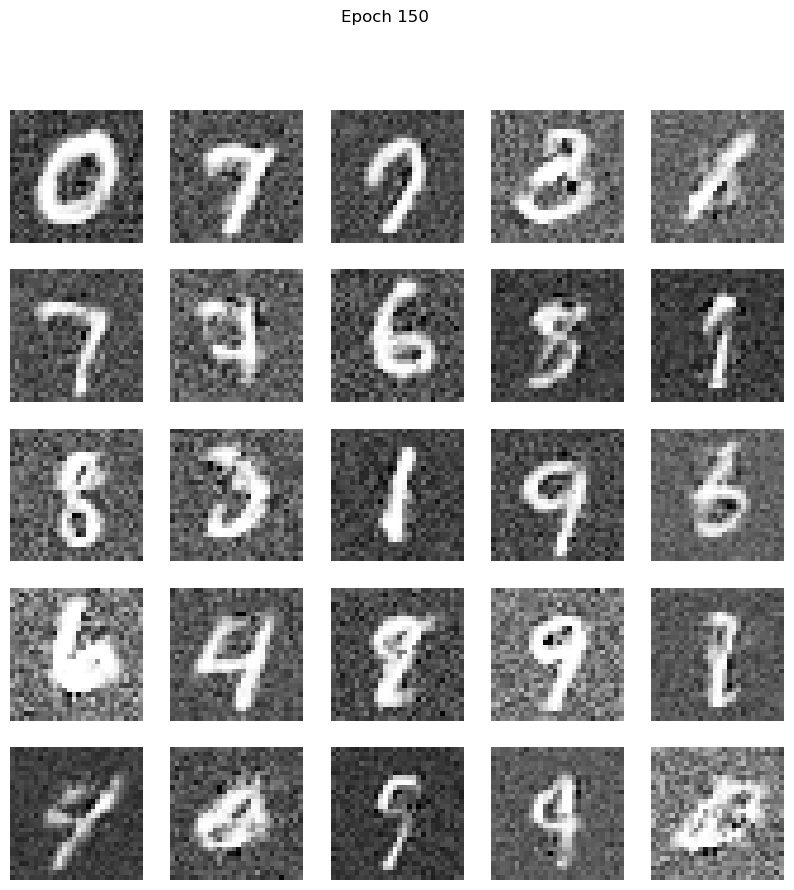

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:12<00:00, 37.52it/s]


Epoch [160/200], d_loss: 0.6646, g_loss: 2.2193


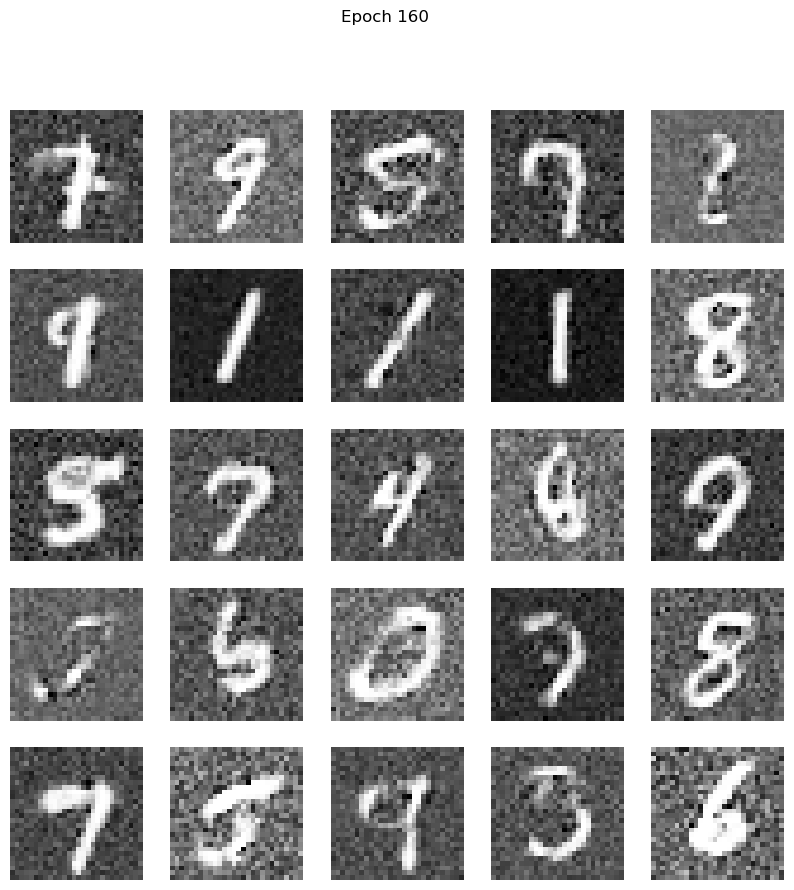

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:13<00:00, 34.75it/s]


Epoch [170/200], d_loss: 0.6388, g_loss: 2.2577


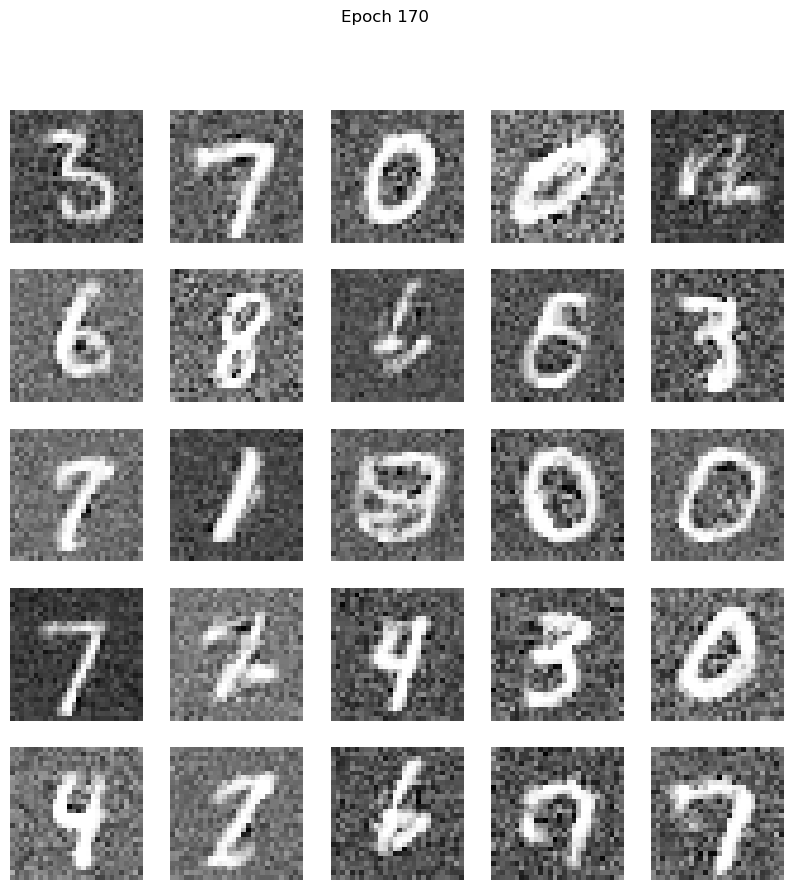

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:14<00:00, 33.19it/s]


Epoch [180/200], d_loss: 0.6324, g_loss: 2.3264


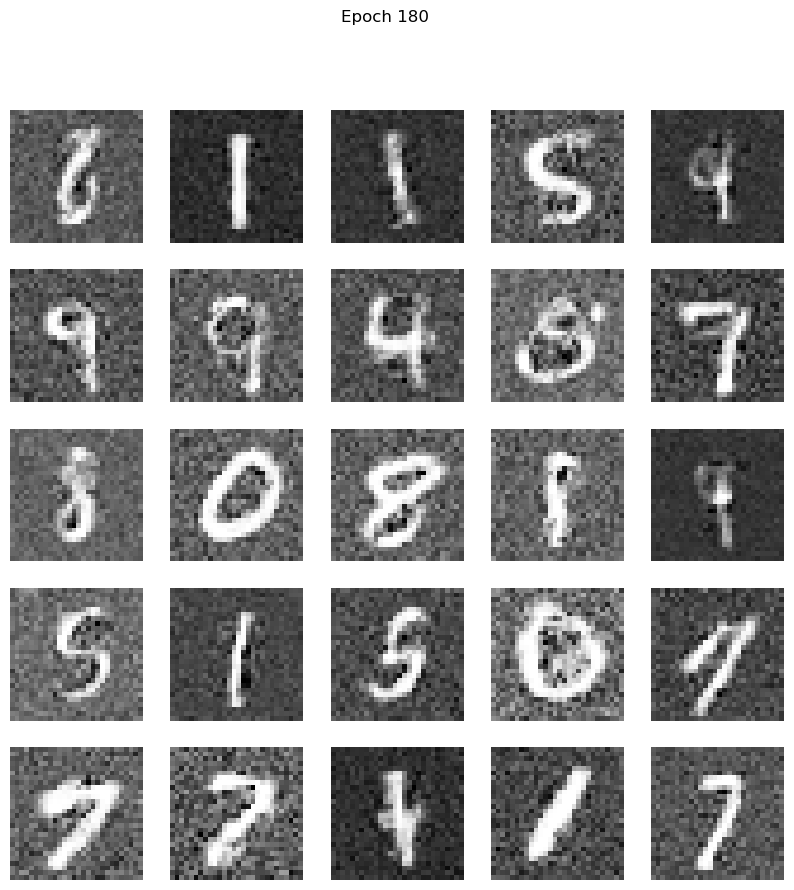

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:14<00:00, 31.99it/s]


Epoch [190/200], d_loss: 0.6194, g_loss: 2.3510


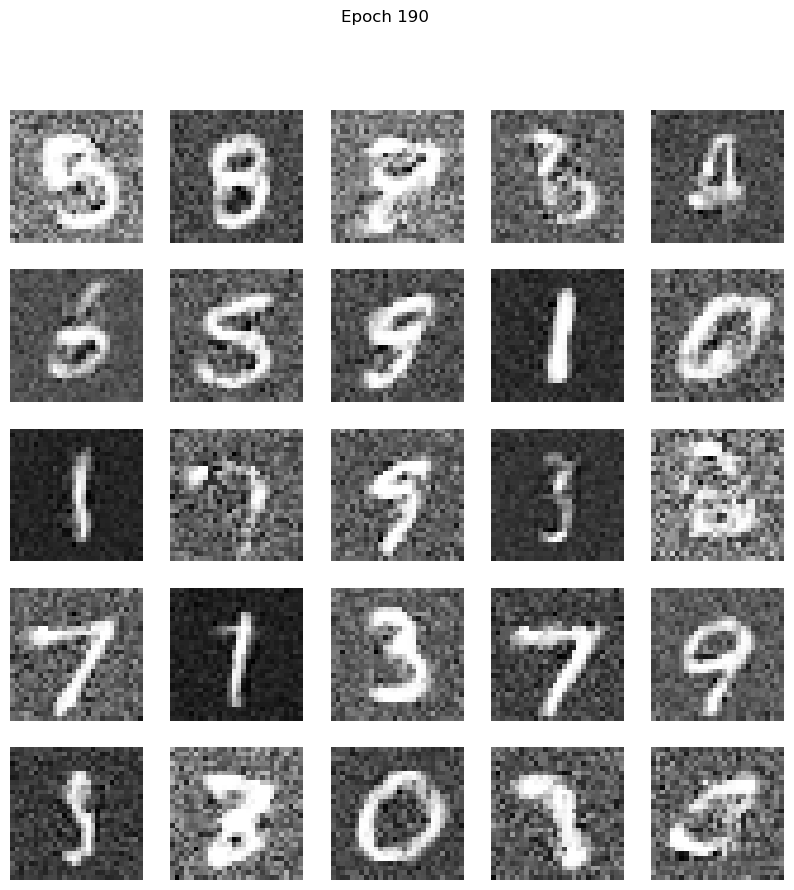

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:12<00:00, 37.83it/s]


Epoch [200/200], d_loss: 0.6220, g_loss: 2.3567


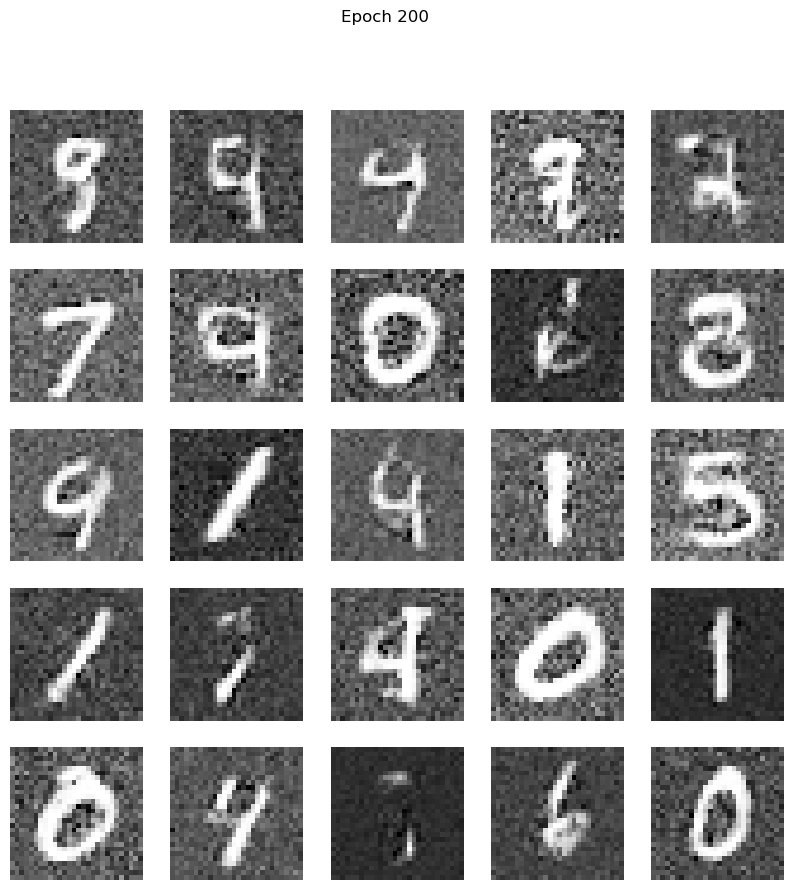

Training finished!


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize models
discriminator = Discriminator().to(device)
generator = Generator().to(device)

# Define loss function and optimizers
criterion = nn.BCELoss()
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training parameters
num_epochs = 200
latent_dim = 100  # Latent space dimension for generator input
d_steps = 1  # Number of discriminator steps per iteration
g_steps = 1  # Number of generator steps per iteration

# Start training
print("Starting Training...")
for epoch in range(num_epochs):
    d_losses = []
    g_losses = []
    for i, (real_images, _) in enumerate(tqdm(train_loader)):
        batch_size = real_images.size(0)
        real_images = real_images.to(device)

        # Train Discriminator
        for _ in range(d_steps):
            d_optimizer.zero_grad()

            # Real images
            label_real = torch.ones(batch_size, 1).to(device)  # Label 1 for real images
            output_real = discriminator(real_images)
            d_loss_real = criterion(output_real, label_real)

            # Fake images
            z = torch.randn(batch_size, latent_dim).to(device)  # Random noise for generator
            fake_images = generator(z)
            label_fake = torch.zeros(batch_size, 1).to(device)  # Label 0 for fake images
            output_fake = discriminator(fake_images.detach())  # Detach to avoid generator gradients
            d_loss_fake = criterion(output_fake, label_fake)

            # Total discriminator loss
            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            d_optimizer.step()

        d_losses.append(d_loss.item())

        # Train Generator
        for _ in range(g_steps):
            g_optimizer.zero_grad()

            # Generate fake images
            z = torch.randn(batch_size, latent_dim).to(device)
            fake_images = generator(z)
            output = discriminator(fake_images)

            # Generator tries to fool discriminator (label 1 for fake images)
            label_real_for_g = torch.ones(batch_size, 1).to(device)
            g_loss = criterion(output, label_real_for_g)
            g_loss.backward()
            g_optimizer.step()

        g_losses.append(g_loss.item())

    # Log and generate sample images every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], d_loss: {np.mean(d_losses):.4f}, g_loss: {np.mean(g_losses):.4f}')
        with torch.no_grad():
            test_z = torch.randn(25, latent_dim).to(device)
            generated = generator(test_z)
            plt.figure(figsize=(10, 10))
            for i in range(25):
                plt.subplot(5, 5, i+1)
                plt.imshow(generated[i].cpu().squeeze(), cmap='gray')
                plt.axis('off')
            plt.suptitle(f'Epoch {epoch+1}')
            plt.show()

print("Training finished!")
